#### Bonescan with different iamge process

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

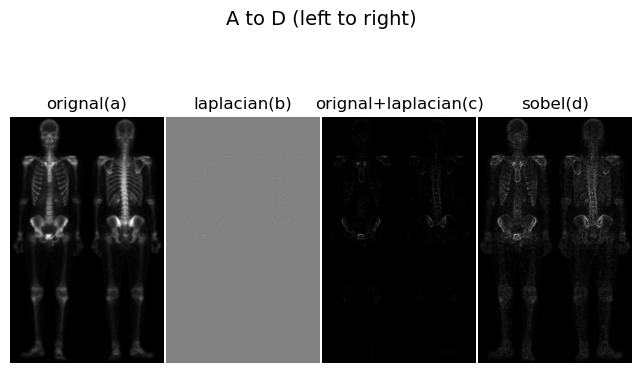

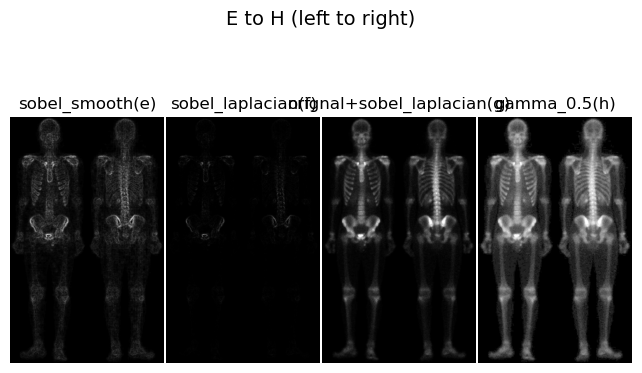

In [11]:
def createFigure(windowName, title, subTitle, image):
    plt.figure(windowName)
    plt.subplots_adjust(left=0.014, right=1-0.014, top=1, bottom=0,hspace=0.2, wspace=0.014)
    plt.suptitle(title, fontsize=14)
    for st,loc,img in zip(subTitle,range(141,145),image):
        setPosition(title=st, position=loc, image=img)
        
def setPosition(title, position, image):
    plt.subplot(position)
    plt.title(title)
    plt.imshow(image, cmap="gray",aspect="equal")
    plt.axis('off')

def Laplacian(image):
    
    kernel = np.array([[-1, -1, -1], 
                       [-1,  8, -1],
                       [-1, -1, -1]])
    
    laplacian = cv2.filter2D(image, cv2.CV_32F, kernel) 
    g_m = laplacian - laplacian.min()
    L_rescale=(g_m/(g_m.max()-g_m.min()))*255 #rescale[0,255]並轉回原來的uint8形式
    return cv2.convertScaleAbs(L_rescale), cv2.convertScaleAbs(laplacian)

def Sobel(image):
    kernel_UD = np.array([[-1, -2, -1],
                          [ 0,  0,  0],
                          [ 1,  2,  1]])
    kernel_LR = np.array([[-1,  0,  1],
                          [-2,  0,  2],
                          [-1,  0,  1]])
    sobel = cv2.addWeighted(cv2.convertScaleAbs(cv2.filter2D(image, cv2.CV_32F, kernel_UD)),0.5,
                            cv2.convertScaleAbs(cv2.filter2D(image, cv2.CV_32F, kernel_LR)),0.5,0)
    sobel_math =  (cv2.filter2D(image, cv2.CV_32F, kernel_UD)**2 + cv2.filter2D(image, cv2.CV_32F, kernel_LR)**2)**0.5
    sobel_math =cv2.addWeighted(cv2.convertScaleAbs(cv2.filter2D(image, cv2.CV_32F, kernel_UD)),1,
                            cv2.convertScaleAbs(cv2.filter2D(image, cv2.CV_32F, kernel_LR)),1,0)
    return sobel, cv2.convertScaleAbs(sobel_math)

def Sobel_BoxFilter(image):
    box_filter =  np.ones((5,5))/25
    sobel_smooth = cv2.filter2D(image,-1, box_filter)
    return sobel_smooth

def test(img):#410785031
    img = img.astype('int16')
    l = np.clip(cv2.Laplacian(img,cv2.CV_16S, ksize=3),0,255) 
    # clip 只將超出限制的壓成min/max 而不是rescale
    # cv2.Laplacian 的kernel[[0 1 0][1 -4 1][0 1 0]]
    
    sobel_x = cv2.Sobel(img,cv2.CV_16S, dx=1,dy=0,ksize=3)
    sobel_y = cv2.Sobel(img,cv2.CV_16S, dx=0,dy=1,ksize=3)

    a= (np.absolute(sobel_x)+np.absolute(sobel_y))
    sobel_img = np.clip(np.absolute(sobel_x)+np.absolute(sobel_y),0,255)

    # sobel_img 正確但不能確定可以永遠正確
    
    box_filt = np.clip(cv2.boxFilter(sobel_img,cv2.CV_16S, ksize=(5,5)),0,255)
    b = cv2.boxFilter(sobel_img,cv2.CV_16S, ksize=(5,5))
    # b == box_filt
    
    mask = np.clip(cv2.multiply(laplacian,box_filt.astype(np.uint8),scale=1/255),0,255)
    # multiply 相乘很多值都會>255用np.clip將她押乘255就會一片白

    # 檔案要轉回 uint8
    sharp_AF = np.clip(cv2.add(img.astype(np.uint8), mask),0,255)
    
    AF_power = np.clip(255*(sharp_AF/255)**0.4 -20, 0, 255)
    AF_power = np.clip(255*(sharp_AF/255)**0.5, 0, 255)
    g = np.array((255*(orignal_SL/255)**0.5),dtype='uint8')
    AF = 255*(sharp_AF/255)**0.5

if __name__ == '__main__':
    orignal = cv2.imread("./data/bonescan.tif",cv2.IMREAD_GRAYSCALE) #(a)
    laplacian_show, laplacian= Laplacian(image=orignal) #(b)

    orignal_laplacian = cv2.addWeighted(orignal,1,laplacian,1,0) #(c)
    sobel ,sobel_t= Sobel(image=orignal) #(d)
    
    
    sobel_smooth = Sobel_BoxFilter(sobel) #(e)
    sobel_laplacian = cv2.multiply(sobel_smooth, laplacian, scale=1/255) #(f)

    orignal_SL = cv2.addWeighted(orignal,1,sobel_laplacian,1,0) #(g)
    gamma = np.array(1*((orignal_SL)**0.5),dtype='uint8') #(h)

    createFigure(windowName = "A to D", 
                 title = "A to D (left to right)", 
                 subTitle = ["orignal(a)","laplacian(b)","orignal+laplacian(c)","sobel(d)"], 
                 image = [orignal,laplacian_show,sobel_laplacian,sobel])
    createFigure(windowName = "E to H", 
                 title = "E to H (left to right)", 
                 subTitle = ["sobel_smooth(e)","sobel_laplacian(f)","orignal+sobel_laplacian(g)","gamma_0.5(h)"], 
                 image = [sobel_smooth,sobel_laplacian,orignal_SL,gamma])
    plt.show()


#### DFT and IDFT

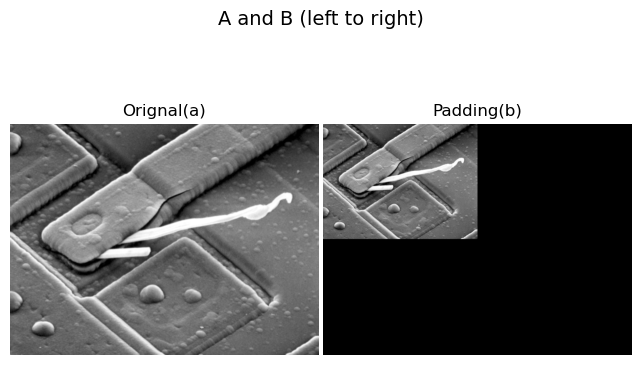

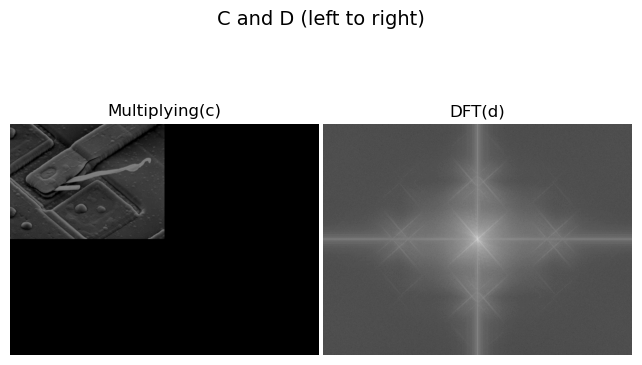

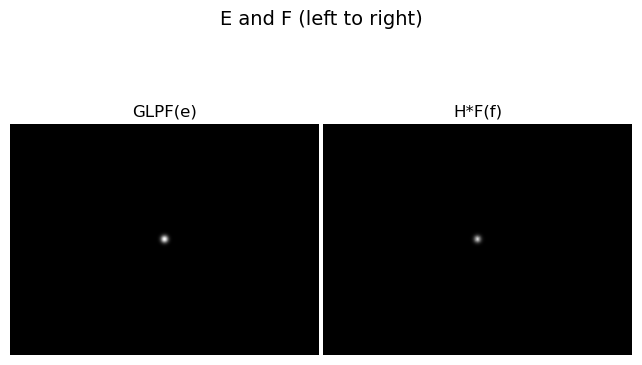

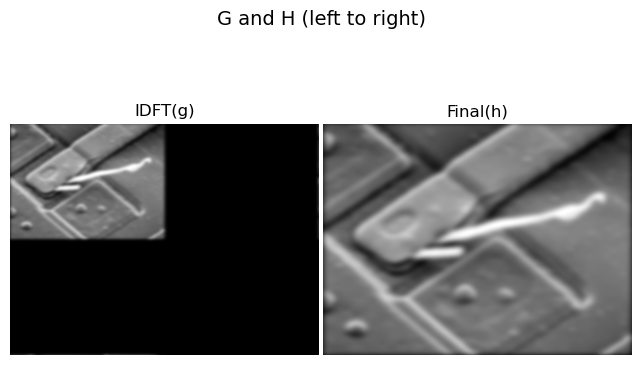

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def imshow(titleSet, subSet, imageSet, count):
    num = 0
    for title in titleSet:
        createFigure(windowName = title,
                    title = title + " (left to right)", 
                    subTitle = subSet[num : num+count], 
                    image = imageSet[num : num+count])
        num+=count

def createFigure(windowName, title, subTitle, image):
    plt.figure(windowName)
    plt.subplots_adjust(left=0.014, right=1-0.014, top=1, bottom=0,hspace=0.2, wspace=0.014)
    plt.suptitle(title, fontsize=14)
    for st,loc,img in zip(subTitle,range(121,123),image):
        setPosition(title=st, position=loc, image=img)

def setPosition(title, position, image):
    plt.subplot(position)
    plt.title(title)
    plt.imshow(image, cmap="gray",aspect="equal")
    plt.axis('off')

def multiplying(img,m,n):
    img = np.array(img,dtype=np.float32)
    for x in range(m):
        for y in range(n):
            if (x+y)%2 == 1:
                img[x][y] = np.array(img[x][y],np.float32)*(-1)
    return img

def DFT(image):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    magnitude_spectrum = np.log(cv2.magnitude(dft[:,:,0], dft[:,:,1]))
    magnitude_spectrum = cv2.convertScaleAbs(magnitude_spectrum)
    magnitude_spectrum=cv2.normalize(magnitude_spectrum,0,255,norm_type=cv2.NORM_MINMAX)
    return magnitude_spectrum, dft # for idft

def GLPF(image, D0=30):
    (row, col) = image.shape
    center_row, center_col = int(row/2),int(col/2)
    mask = np.zeros((row,col))
    mask_2 = np.zeros((row,col,2)) # for idft
    for now_row in range(row):
        for now_col in range(col):
            distance = np.sqrt((now_row-center_row)**2+(now_col-center_col)**2)
            tmp = np.exp(-(distance * distance) / (2 * D0 * D0))
            mask[now_row, now_col]=  tmp
            mask_2[now_row, now_col]= tmp
    return mask, mask_2

def IDFT(image):
    idft = cv2.idft(image)
    magnitude_spectrum = cv2.magnitude(idft[:,:,0], idft[:,:,1])
    magnitude_spectrum=cv2.normalize(magnitude_spectrum,0,255,norm_type=cv2.NORM_MINMAX)
    return magnitude_spectrum

if __name__ == '__main__':
    orignal = cv2.imread("./data/integrated-ckt-damaged.tif",cv2.IMREAD_GRAYSCALE) #(a)
    (M,N) = orignal.shape
    orignal = cv2.resize(orignal,(2*N,2*M))
    (M,N) = orignal.shape
    padding = cv2.copyMakeBorder(orignal, 0, M, 0, N, cv2.BORDER_CONSTANT, value=0) #(b)
    moveToCenter = multiplying(padding.copy(),M,N) #(b)
    dft, tmp_dft = DFT(moveToCenter) #(d)
    # Centered Gaussian lowpass filter transfer function
    glpf, tmp_glpf= GLPF(dft) #(e)
    hf = glpf * dft #(f)
    #IDFT
    idft = IDFT(tmp_dft*tmp_glpf) #(g)
    #split
    final = idft[:M,:N] #(h)
    np.clip(moveToCenter, 0, 255, moveToCenter) #用於展示(c)
    imshow( titleSet = ["A and B", "C and D", "E and F", "G and H"],
            subSet = ["Orignal(a)","Padding(b)","Multiplying(c)","DFT(d)","GLPF(e)","H*F(f)","IDFT(g)","Final(h)"],
            imageSet = [orignal,padding,moveToCenter,dft,glpf,hf,idft,final],
            count=2)
    plt.show()


#### WaterShed

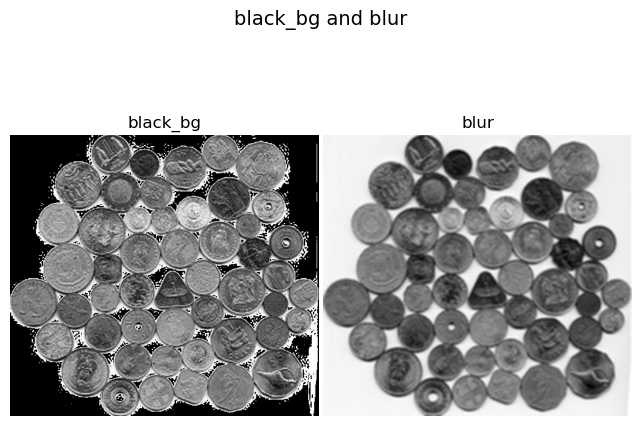

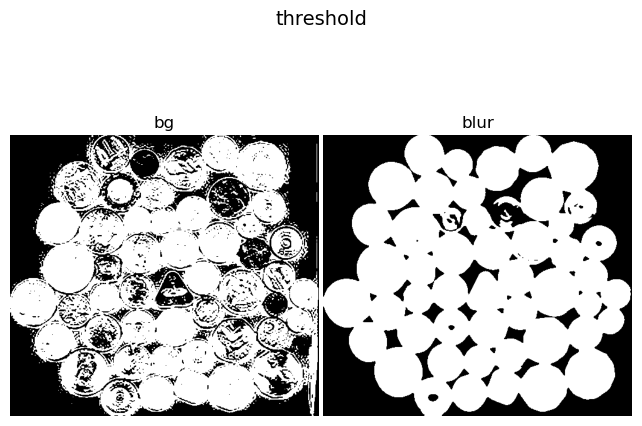

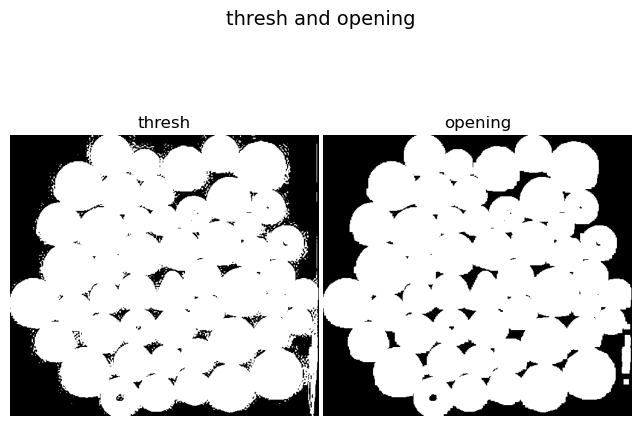

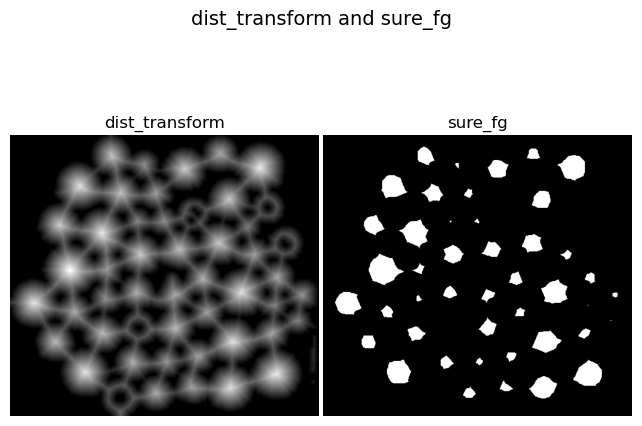

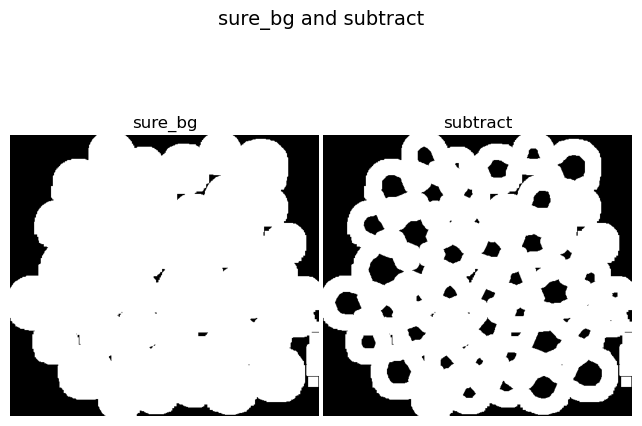

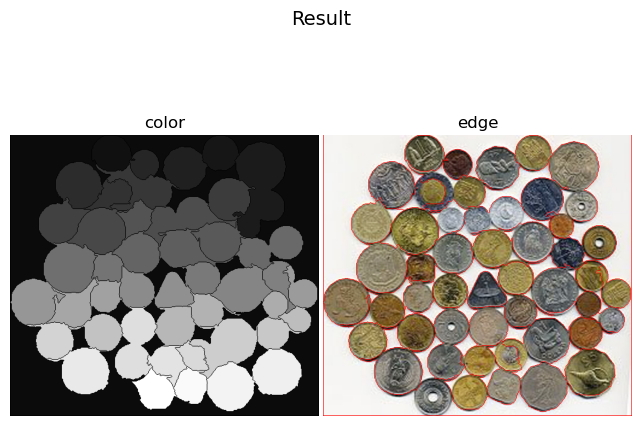

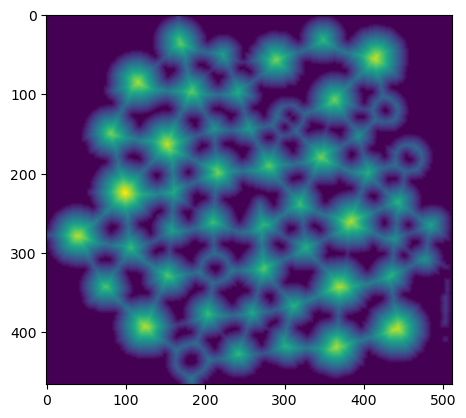

[INFO] 40 unique segments found


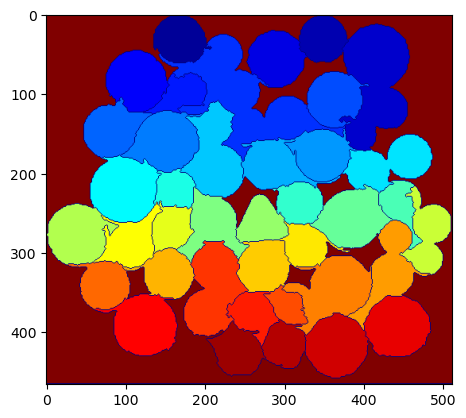

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import label
def segment_on_dt(a, img):
    border = cv2.dilate(img, None, iterations=5)
    border = border - cv2.erode(border, None)

    dt = cv2.distanceTransform(img, cv2.DIST_L2, 3)
    plt.imshow(dt)
    plt.show()
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
    _, dt = cv2.threshold(dt, 140, 255, cv2.THRESH_BINARY)
    lbl, ncc = label(dt)
    lbl = lbl * (255 / (ncc + 1))
    # Completing the markers now.
    lbl[border == 255] = 255

    lbl = lbl.astype(np.int32)
    cv2.watershed(a, lbl)
    print("[INFO] {} unique segments found".format(len(np.unique(lbl)) - 1))
    lbl[lbl == -1] = 0
    lbl = lbl.astype(np.uint8)
    return 255 - lbl
def single(img):
    plt.imshow(img, cmap="gray",aspect="equal")
    plt.show()

def imshow(titleSet, subSet, imageSet, count):
    num = 0
    for title in titleSet:
        createFigure(windowName = title,
              title = title, 
              subTitle = subSet[num : num+count], 
              image = imageSet[num : num+count])
        num+=count

def createFigure(windowName, title, subTitle, image):
    plt.figure(windowName)
    plt.subplots_adjust(left=0.014, right=1-0.014, top=0.85, bottom=0,hspace=0.2, wspace=0.014)
    plt.suptitle(title, fontsize=14)
    for st,loc,img in zip(subTitle,range(121,123),image):
        setPosition(title=st, position=loc, image=img)

def setPosition(title, position, image):
    plt.subplot(position)
    plt.title(title)
    plt.imshow(image, cmap="gray",aspect="equal")
    plt.axis('off')


if __name__ == '__main__':
    img = cv2.imread("./data/coins.jpg")
    orignal=cv2.applyColorMap(img, cv2.COLORMAP_BONE)
    orignal = cv2.cvtColor(orignal,cv2.COLOR_BGR2GRAY)
    blur = cv2.blur(orignal,(5,5))
    orignal[orignal>235]=0
    imshow(titleSet=["black_bg and blur"],subSet=["black_bg","blur"],imageSet=[orignal,blur],count=2)

    ret, thresh_bg = cv2.threshold(orignal,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret2, thresh_blur = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    thresh = cv2.add(thresh_bg,thresh_blur)
    imshow(titleSet=["threshold"],subSet=["bg","blur"],imageSet=[thresh_bg,thresh_blur],count=2)

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 4)
    imshow(titleSet=["thresh and opening"],subSet=["thresh","opening"],imageSet=[thresh,opening],count=2)

    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
    ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
    imshow(titleSet=["dist_transform and sure_fg"],subSet=["dist_transform","sure_fg"],imageSet=[dist_transform, sure_fg],count=2)

    kernel = np.ones((3,3),np.uint8)
    sure_bg = cv2.dilate(opening,kernel,iterations=4)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    imshow(titleSet=["sure_bg and subtract"],subSet=["sure_bg","subtract"],imageSet=[sure_bg,unknown],count=2)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [0,0,255]
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    imshow(titleSet=["Result"],subSet=["color","edge"],imageSet=[markers,img],count=2)
    plt.show()
    result=segment_on_dt(img, opening)
    c=cv2.applyColorMap(result, cv2.COLORMAP_JET)
    single(c)

    